<div style="border:solid blue 2px; padding: 20px">

**Overall Summary of the Project**

Hi Elizabeth! You've done a great job organizing this project and addressing all the major tasks in a clean, methodical way. Your project reads smoothly and reflects a strong grasp of both business goals and technical implementation. Here's my feedback:

---

**✅ Strengths**

- **Clear narrative & structure**: Excellent use of markdown for guiding the reader. Each task is clearly labeled and well-explained.
- **Data preparation**: You handled missing values logically using median imputation and properly validated the recovery formula with MAE.
- **Exploratory data analysis**: Your histograms and KDE plots are useful to understand concentrations and distributions across stages. Good catch on anomalies at zero!
- **Custom sMAPE function**: Great job implementing the final sMAPE correctly and applying it throughout cross-validation and testing.
- **Cross-validation**: Your custom `score_model` function is reusable and clean. Well done applying it across models.
- **Model tuning**: Testing different `max_depth` values for the Random Forest and selecting the best based on validation score is a great strategy.

---

**⚠️ Areas for Improvement**

- **Model separation**: You're predicting rougher and final recovery simultaneously, which is fine, but consider using `MultiOutputRegressor` for a cleaner interface or even training two separate models if behavior differs significantly.
- **Hardcoded median for test baseline**: You used `target_test.median()` directly for comparison. That's okay, but it might be clearer to explain what that baseline represents (e.g., naive constant predictor).
- **Model capacity**: Limiting your Random Forest to `max_depth=3` is good for avoiding overfitting, but consider reporting results with slightly larger depths (e.g., 5–10) to evaluate trade-offs.
- **Conclusion**: Solid summary, but you could enhance it by reflecting briefly on how this model could support business decisions (e.g., setting process thresholds or detecting suboptimal batches).

---

**🧠 Code Tip: Using MultiOutputRegressor**

You can simplify your model structure by doing:

<code>
from sklearn.multioutput import MultiOutputRegressor
model = MultiOutputRegressor(RandomForestRegressor(max_depth=3, n_estimators=50, random_state=12345))
model.fit(feature_train, target_train)
predictions = pd.DataFrame(model.predict(feature_test))
print("Final sMAPE:", final_smape(target_test, predictions))
</code>

**🎯 Final Comments**

Elizabeth, your work is thoughtful, thorough, and clear. Your careful preprocessing, targeted modeling, and consistent evaluation demonstrate strong understanding and professionalism. With a bit more modularity in the modeling section and deeper interpretation of business implications, this project would be outstanding.

You’ve built a well-performing pipeline that meets the project objectives. Great work! 🌟

# Zyfra Gold Recovery Model
The purpose of this project is to prepare a machine learning model for the company Zyfra to predict the amount of gold recovered from gold ore in order to optimize the production and eliminate unprofitable parameters. 

The data that we will be using in this analysis comes from the warehouse and includes a training set, a test set and a full raw data set listed below. 

- gold_recovery_train
- gold_recovery_test
- gold_recovery_full

The features of each set may vary and we will analyze that in our data preparation.  All 3 sets include data from the different stages of the purification process, from the feeding of raw material in the rougher/flotation process through the 2 stages of purfication.

## Importing and Preparing the Data

First we will import our data, review it and prepare it so that it is useable for our analysis and to build our model.

In [48]:
#Import Libraries that will be Needed
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np

In [49]:
#Download Dataset

gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [50]:
#Briefly Review the Data

gold_recovery_train.info()
print()
display(gold_recovery_train.sample(5))
print()
gold_recovery_test.info()
print()
display(gold_recovery_test.sample(5))
print()
gold_recovery_full.info()
print()
display(gold_recovery_full.sample(5))
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
14719,2018-05-21 06:59:59,4.374232,10.031947,6.989242,45.688388,68.274200,9.281995,2.271350,8.247289,2.754297,...,29.991224,-500.104950,19.975202,-499.358992,17.995094,-499.778339,13.971208,-499.934705,13.970567,-499.379738
10288,2017-07-18 15:59:59,3.884705,10.632795,11.014994,45.375390,65.191278,7.864000,2.973352,11.322937,2.760131,...,21.979330,-499.727771,18.041990,-380.062208,18.015006,-500.170158,14.989919,-500.127435,14.999063,-499.813246
8263,2017-04-25 06:59:59,4.003799,11.296766,9.594314,45.568948,67.498434,7.993316,2.949169,10.448115,2.679689,...,25.008120,-399.639899,22.999007,-398.325754,25.998782,-449.222640,23.986027,-450.000090,29.997461,-500.090349
2687,2016-05-05 22:59:59,5.316717,10.322508,9.642727,44.883788,61.043971,7.672718,2.156194,13.954564,3.472332,...,14.028202,-525.847142,11.940975,-494.046705,11.017386,-501.854233,10.009555,-485.377373,20.000423,-512.600216
10790,2017-08-08 13:59:59,4.277734,11.220356,7.267760,45.379260,71.028405,7.322671,3.022871,10.867401,2.170327,...,18.013891,-501.439683,12.130562,-400.590537,15.968718,-500.749616,12.007215,-500.212206,15.016131,-500.237873



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_cle

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
3451,2017-09-22 19:59:59,151.257650,4.632540,7.38,0.436973,1352.875018,-501.791319,1349.754320,-499.975707,1349.595958,...,12.051332,-497.897222,9.069381,-398.437397,9.055660,-491.466602,6.957189,-449.942944,9.990038,-499.365307
2009,2016-11-23 17:59:59,199.000974,7.018688,7.38,1.499629,1608.112580,-500.597585,1605.323368,-498.132925,1596.622005,...,18.022652,-498.489534,16.014770,-497.156103,15.241494,-500.679859,11.996026,-500.117489,21.971650,-499.607499
5687,2017-12-24 23:59:59,213.458761,14.984599,8.44,1.009755,1598.213736,-399.692726,1599.608921,-399.657129,1324.932506,...,20.000054,-499.941564,15.077450,-499.804520,11.022535,-499.819608,8.987165,-499.960061,11.979863,-499.299036
2209,2016-12-02 01:59:59,258.234033,8.405344,7.52,1.188011,1498.265982,-499.548352,1499.824956,-499.445062,1502.955602,...,18.003114,-500.670694,15.881235,-499.994919,16.730049,-501.684948,12.006862,-500.417360,21.996657,-500.642623
2632,2016-12-19 16:59:59,201.188691,11.004008,7.41,1.406780,1501.715086,-500.610315,1501.712243,-510.421710,1501.382957,...,17.007886,-498.358402,15.059779,-439.727711,13.886569,-501.558245,12.016874,-501.139001,21.024495,-500.860908



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
16213,2017-11-20 12:59:59,7.940269,9.608015,9.694418,39.978908,73.236294,12.613900,2.776996,10.808606,3.678565,...,17.020199,-498.684848,14.948051,-500.808139,11.012526,-496.179690,9.038347,-468.057918,15.984135,-495.957053
19474,2018-04-05 09:59:59,4.991868,11.026155,10.060128,45.030940,58.885488,10.158332,1.872035,7.215802,2.559894,...,23.006991,-493.396178,16.002977,-469.326560,22.008493,-500.056975,14.013363,-463.828361,12.989786,-500.248231
8109,2016-12-17 20:59:59,6.138280,9.582095,12.989064,42.556274,76.190400,11.492642,3.253350,7.653705,2.840185,...,17.020850,-501.281412,14.969280,-499.123659,17.794517,-499.347569,11.991430,-499.914802,21.004413,-501.238213
17887,2018-01-29 06:59:59,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,19.954014,-501.170477,14.921392,-500.245768,10.925963,-794.565016,8.971267,-793.145347,11.011653,-803.172576
16443,2017-11-30 02:59:59,0.000000,0.000000,0.000000,0.000000,0.000000,10.773057,2.788020,10.943107,5.597470,...,16.955913,-502.374335,15.087714,-361.338836,11.033323,-411.774309,8.991549,-259.669885,12.001940,-294.817404


For our first task 1.2 Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.  We will do this before we prepare the data for analysis

In [51]:
# Define the columns that we will need for our rougher calculation and the actual for our MAE calculation
#recovery = (C*(F-T))/(F*(C-T))*100, Define these columns
c_train = gold_recovery_train['rougher.output.concentrate_au']
f_train = gold_recovery_train['rougher.input.feed_au']
t_train = gold_recovery_train['rougher.output.tail_au']
#Define actual_recovery
actual_recovery = gold_recovery_train['rougher.output.recovery']

In [52]:
#calculate predicted recovery
calculated_recovery = ((c_train*(f_train-t_train))/(f_train*(c_train-t_train))*100)
print(calculated_recovery)

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 16860, dtype: float64


In [53]:
mae = np.mean(np.abs(actual_recovery - calculated_recovery))
print("Mean Absolute Error:", mae)

Mean Absolute Error: 9.303415616264301e-15


Here we can see that our MAE between the calculated recovery from the training set and the actual is incredibly small which indicates that our training model (in this case our recovery equation) is very accurate and closely resembles the actual recovery.

In [54]:
#1.3 Analyze features not available in the test set.
diff_features_full_train = list(set(gold_recovery_full.columns) - set(gold_recovery_train.columns))
print(diff_features_full_train) #confirming there are no columns between the full data set and the training set
print()
diff_features = list(set(gold_recovery_train.columns) - set(gold_recovery_test.columns))
train_only_features = gold_recovery_train[diff_features]
train_only_features.info()

[]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.output.concentrate_au                       16778 non-null  float64
 1   rougher.calculation.sulfate_to_au_concentrate       16833 non-null  float64
 2   final.output.recovery                               15339 non-null  float64
 3   primary_cleaner.output.concentrate_ag               16778 non-null  float64
 4   primary_cleaner.output.concentrate_au               16778 non-null  float64
 5   final.output.concentrate_ag                         16788 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   primary_cleaner.output.concentrate_sol              16224 non-null  float64
 8   secondary_cleaner.output.tail_sol                   14874 non-null  floa

Here we can see that there are 33 features that are in our training set, but are not available in our test set.  We can see that these features are all different output values throughout the mining process. They are likely missing from our test set as these are the values that are dependent on other steps throughout the process.  We will likely be predicting many of these values with our model.  They are all float type data. 

1.4 Now we will perform all data preprocessing to prepare the data for analysis.

In [55]:
#in all 3 datasets we can change the date data type to date time
gold_recovery_train['date'] = pd.to_datetime(gold_recovery_train['date'], format= '%Y-%m-%d %H:%M:%S')
print(gold_recovery_train['date'].dtype)
print()
gold_recovery_test['date'] = pd.to_datetime(gold_recovery_test['date'], format= '%Y-%m-%d %H:%M:%S')
print(gold_recovery_test['date'].dtype)
print()
gold_recovery_full['date'] = pd.to_datetime(gold_recovery_full['date'], format= '%Y-%m-%d %H:%M:%S')
print(gold_recovery_full['date'].dtype)

datetime64[ns]

datetime64[ns]

datetime64[ns]


Now we will go through missing values and duplicate values for each data set and determine how we want to handle these. We will start with our training set.

In [56]:
# Now we will look for missing values in each column and we can determine based on the percentage of values if we want to drop or fill them
print(gold_recovery_train.isna().sum().sort_values(ascending=False))
print((gold_recovery_train.isna().sum()/len(gold_recovery_train)).sort_values(ascending=False).head(20)) #finding the percentage of missing values

rougher.output.recovery                               2573
rougher.output.tail_ag                                2250
rougher.output.tail_sol                               2249
rougher.output.tail_au                                2249
secondary_cleaner.output.tail_sol                     1986
                                                      ... 
primary_cleaner.state.floatbank8_d_level                27
rougher.calculation.floatbank10_sulfate_to_au_feed      27
rougher.calculation.floatbank11_sulfate_to_au_feed      27
primary_cleaner.input.feed_size                          0
date                                                     0
Length: 87, dtype: int64
rougher.output.recovery                     0.152610
rougher.output.tail_ag                      0.133452
rougher.output.tail_sol                     0.133393
rougher.output.tail_au                      0.133393
secondary_cleaner.output.tail_sol           0.117794
rougher.input.floatbank11_xanthate          0.112930
final.ou

Based on this we will drop all missing values that are less than 5% of our data.  Anything greater than that we will look at the data distribution and determine if we want to fill the missing values with the mean or median values. 

In [57]:
train_cols_to_fillna = gold_recovery_train.isna().sum().nlargest(12).index
print(train_cols_to_fillna)

Index(['rougher.output.recovery', 'rougher.output.tail_ag',
       'rougher.output.tail_sol', 'rougher.output.tail_au',
       'secondary_cleaner.output.tail_sol',
       'rougher.input.floatbank11_xanthate', 'final.output.recovery',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'rougher.calculation.au_pb_ratio', 'rougher.input.floatbank10_sulfate',
       'primary_cleaner.input.xanthate'],
      dtype='object')


In [58]:
#now we want to determine weather to fill these values with the mean or median value. To do that we will get the data descriptions and plot graphs
display(gold_recovery_train[train_cols_to_fillna].describe())

,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_sol,rougher.input.floatbank11_xanthate,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,rougher.calculation.au_pb_ratio,rougher.input.floatbank10_sulfate,primary_cleaner.input.xanthate
count,14287.000000,14610.000000,14611.000000,14611.000000,14874.000000,14956.000000,15339.000000,15553.000000,15598.000000,15618.000000,15816.000000,15875.000000
mean,82.394201,5.566579,17.865309,1.763930,6.181742,5.792970,67.213166,129.479789,8.625021,2.327953,11.198142,0.843812
std,15.096808,1.045456,3.455588,0.731518,4.460622,1.294180,11.960446,45.386931,3.698633,0.899125,3.964080,0.419098
min,0.000000,0.594562,10.014648,0.020676,0.000000,0.000010,0.000000,0.000003,0.000000,-0.010548,0.000002,0.000005
25%,79.818372,4.918713,15.646980,1.311610,2.045824,5.097006,62.625685,103.064021,6.004886,1.979046,9.366078,0.568934
50%,85.235997,5.718038,17.996971,1.747907,6.194420,5.995942,67.644601,131.783108,8.016531,2.229144,11.179351,0.844271
75%,90.131691,6.308490,19.933255,2.190839,10.252499,6.695277,72.824595,159.539839,11.437819,2.637776,13.203315,1.097080
max,100.000000,12.719177,66.117188,9.688980,33.058594,9.698407,100.000000,251.999948,40.000000,39.379272,36.118275,6.027907


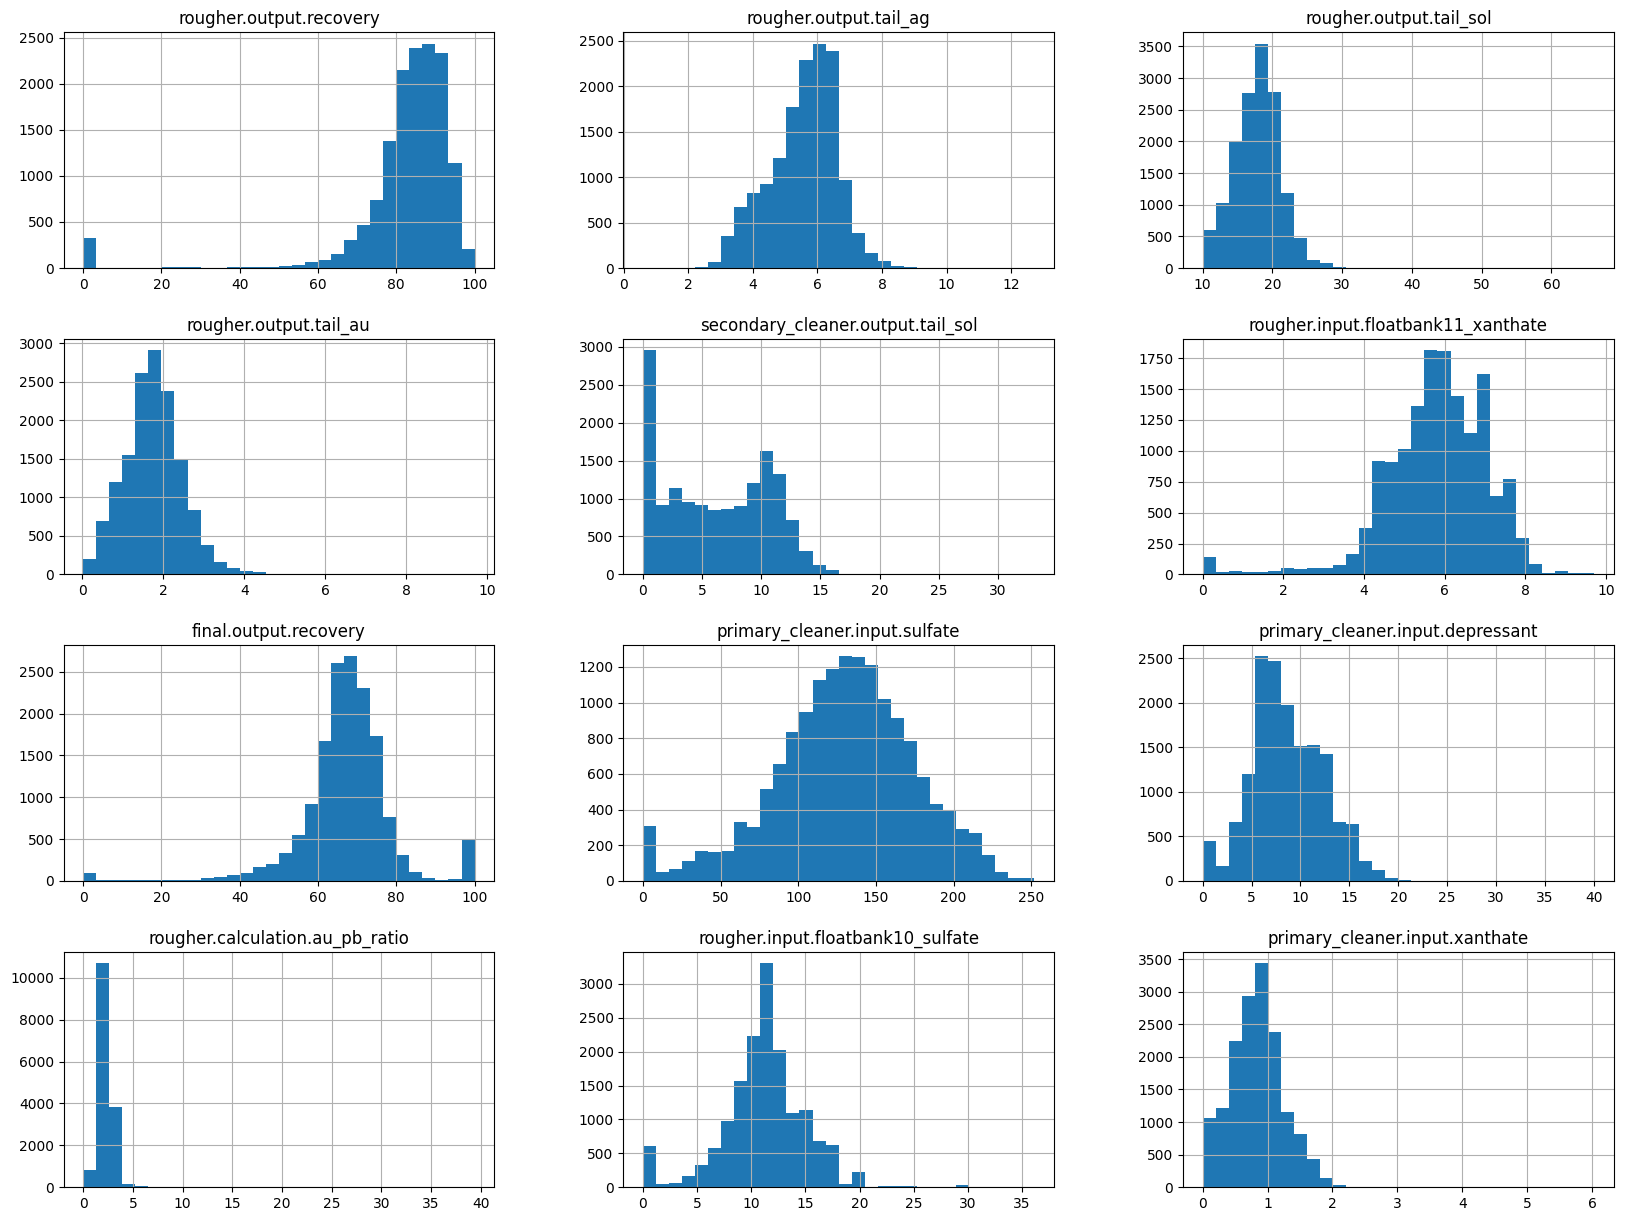

In [59]:
#histograms
gold_recovery_train[train_cols_to_fillna].hist(bins=30, figsize= (20,15))
plt.show()

Based on the distributions of all these columns with over 5% of their data missing, there seems to be outliers that skew the data in most besides primary_cleaner.input_sulfate.  Therefore, we will fill all these missing values with their respective median value.

In [60]:
# Fill missing values in these columns 
for col in train_cols_to_fillna:
    gold_recovery_train[col].fillna(gold_recovery_train[col].median(), inplace=True)

# then we will drop any rows that still have missing values in other columns
gold_recovery_train.dropna(inplace=True)

#check that we took care of all the missing values for our training set
print(gold_recovery_train.isna().sum().sum())

0


In [61]:
#check for duplicates
print(gold_recovery_train.duplicated().sum())

0


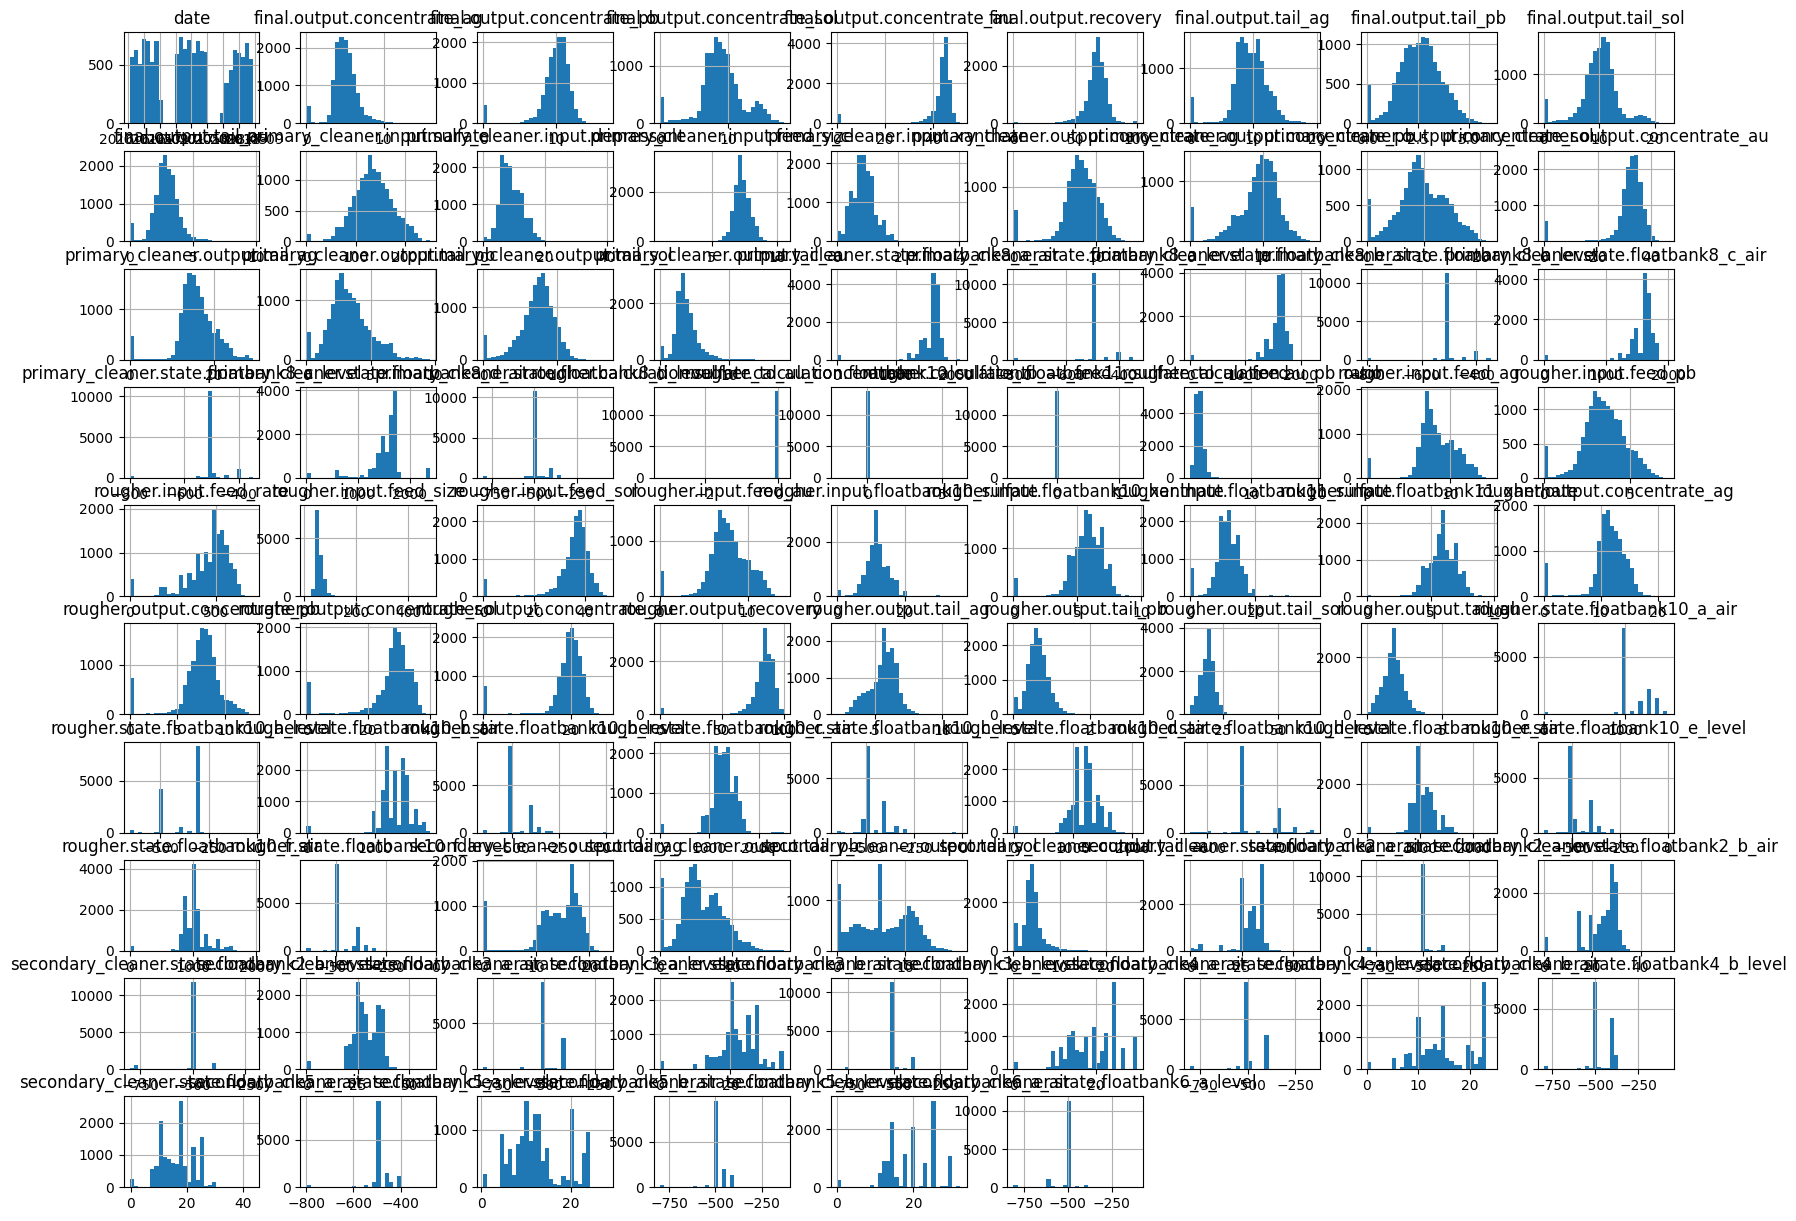

In [62]:
# Finally for our training set, we want to get an idea of the distributions for each column. We will do this visually with histograms
gold_recovery_train.hist(bins=30, figsize= (20,15))
plt.show()

As we dive deeper into our analysis in the later sections we can dig deeper into columns where it makes more sense.  These are not the most detailed or super easy to read, but can give us a quick idea of how the data is distributed.  We will go through all the above steps again now for our test set.

In [63]:
# Determine missing values and what percentage of the data are missing 
print(gold_recovery_test.isna().sum().sort_values(ascending=False))
print((gold_recovery_test.isnull().sum()/len(gold_recovery_test)).sort_values(ascending=False).head(20)) #finding the percentage of missing values

rougher.input.floatbank11_xanthate            353
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
rougher.input.floatbank10_sulfate             257
primary_cleaner.input.xanthate                166
rougher.input.floatbank10_xanthate            123
rougher.input.feed_sol                         67
rougher.input.floatbank11_sulfate              55
rougher.input.feed_rate                        40
secondary_cleaner.state.floatbank3_a_air       34
secondary_cleaner.state.floatbank2_b_air       23
rougher.input.feed_size                        22
secondary_cleaner.state.floatbank2_a_air       20
rougher.state.floatbank10_a_air                17
rougher.state.floatbank10_c_air                17
rougher.state.floatbank10_d_air                17
rougher.state.floatbank10_e_air                17
rougher.state.floatbank10_b_air                17
rougher.state.floatbank10_f_air                17
secondary_cleaner.state.floatbank3_a_level     16


Overall we are missing far less values in our test set. Likely because most of the columns in our trianing set with a large number of missing values are values that are calculated later and are not in our test set. Maintaining the standard we set above we will fill missing values above 5% and drop missing values below that.

In [64]:
test_cols_to_fillna = gold_recovery_test.isna().sum().nlargest(2).index
print(test_cols_to_fillna)

Index(['rougher.input.floatbank11_xanthate', 'primary_cleaner.input.sulfate'], dtype='object')


,rougher.input.floatbank11_xanthate,primary_cleaner.input.sulfate
count,5503.000000,5554.000000
mean,6.423566,170.515243
std,1.120371,49.608602
min,0.000055,0.000103
25%,5.994363,143.340022
50%,6.496105,176.103893
75%,7.008034,207.240761
max,18.709478,274.409626


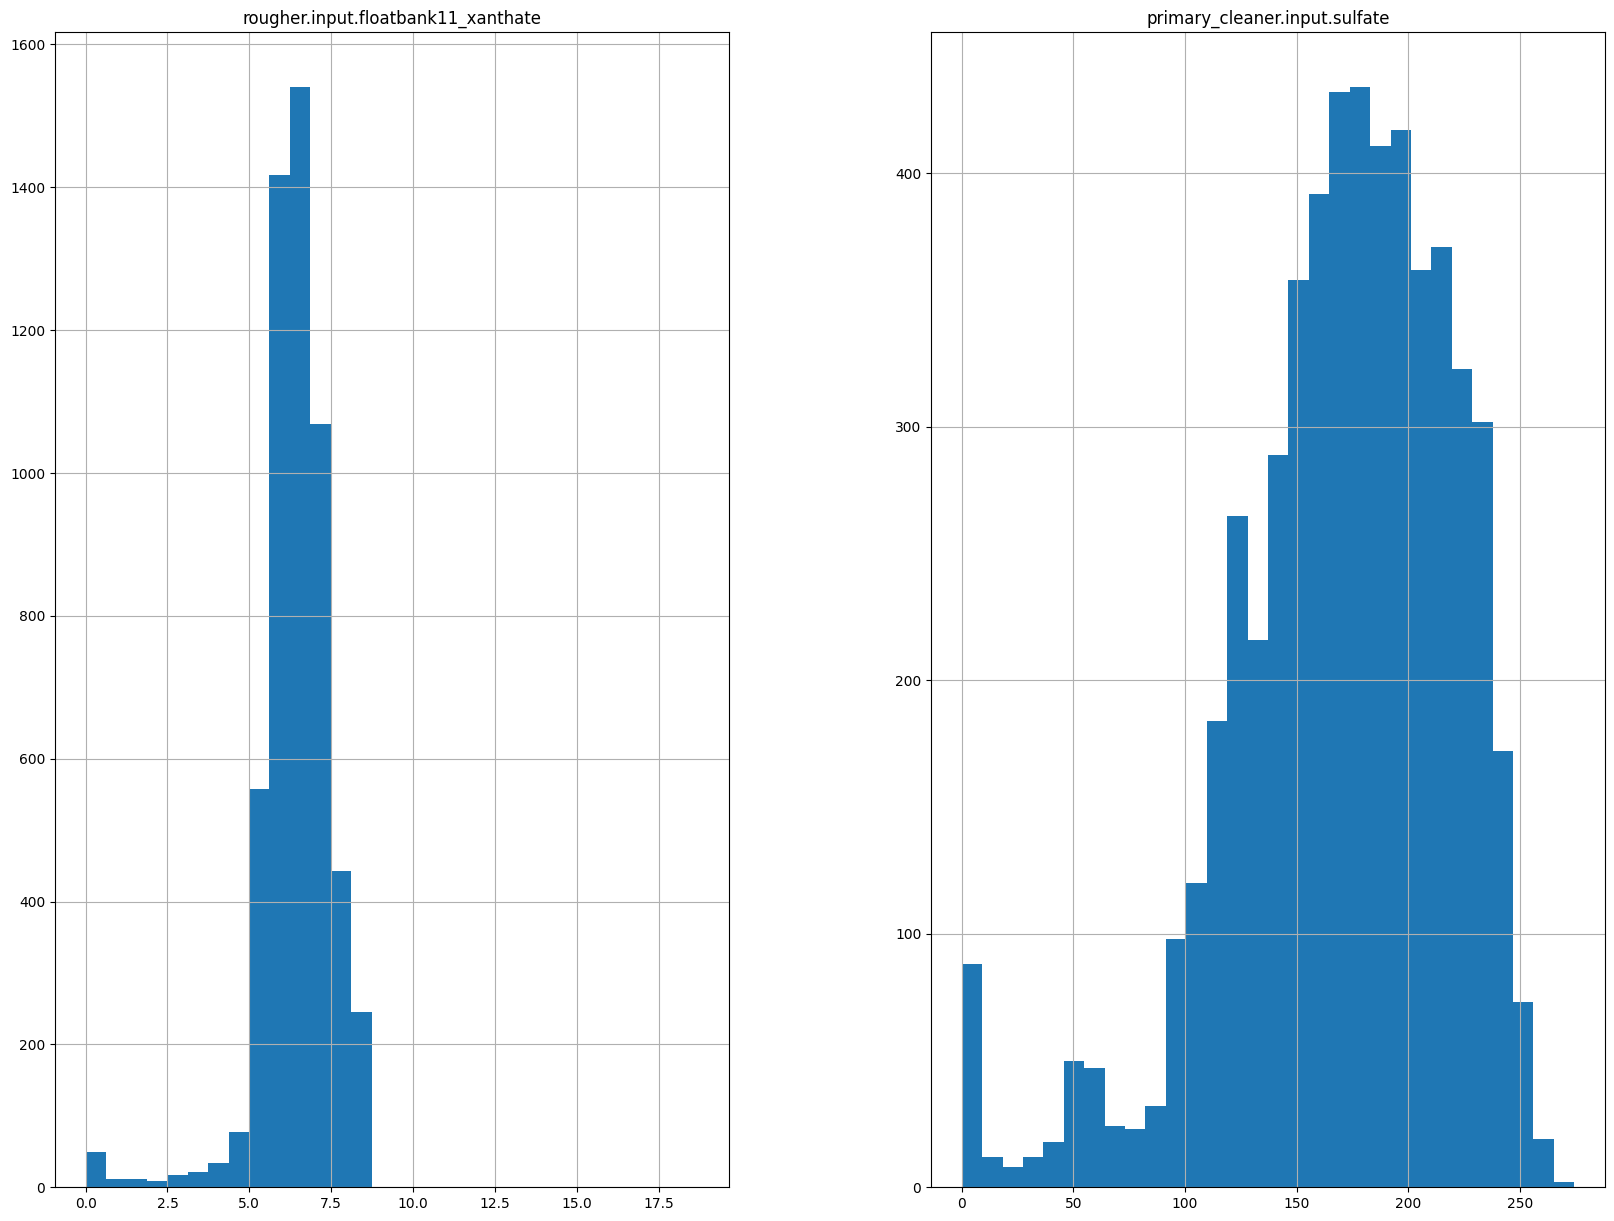

In [65]:
#Determine weather to fill these values with the mean or median value. 
display(gold_recovery_test[test_cols_to_fillna].describe())
#histograms
gold_recovery_test[test_cols_to_fillna].hist(bins=30, figsize= (20,15))
plt.show()

Both these columns are fairly normally distributed with some outliers that skew it to the left. We will fill the missing values with their medians.

In [66]:
# Fill missing values in these columns 
for col in test_cols_to_fillna:
    gold_recovery_test[col].fillna(gold_recovery_test[col].median(), inplace=True)

# then we will drop any rows that still have missing values in other columns
gold_recovery_test.dropna(inplace=True)

#check that we took care of all the missing values for our training set
print(gold_recovery_test.isna().sum().sum())

0


In [67]:
#check for duplicates
print(gold_recovery_test.duplicated().sum())

0


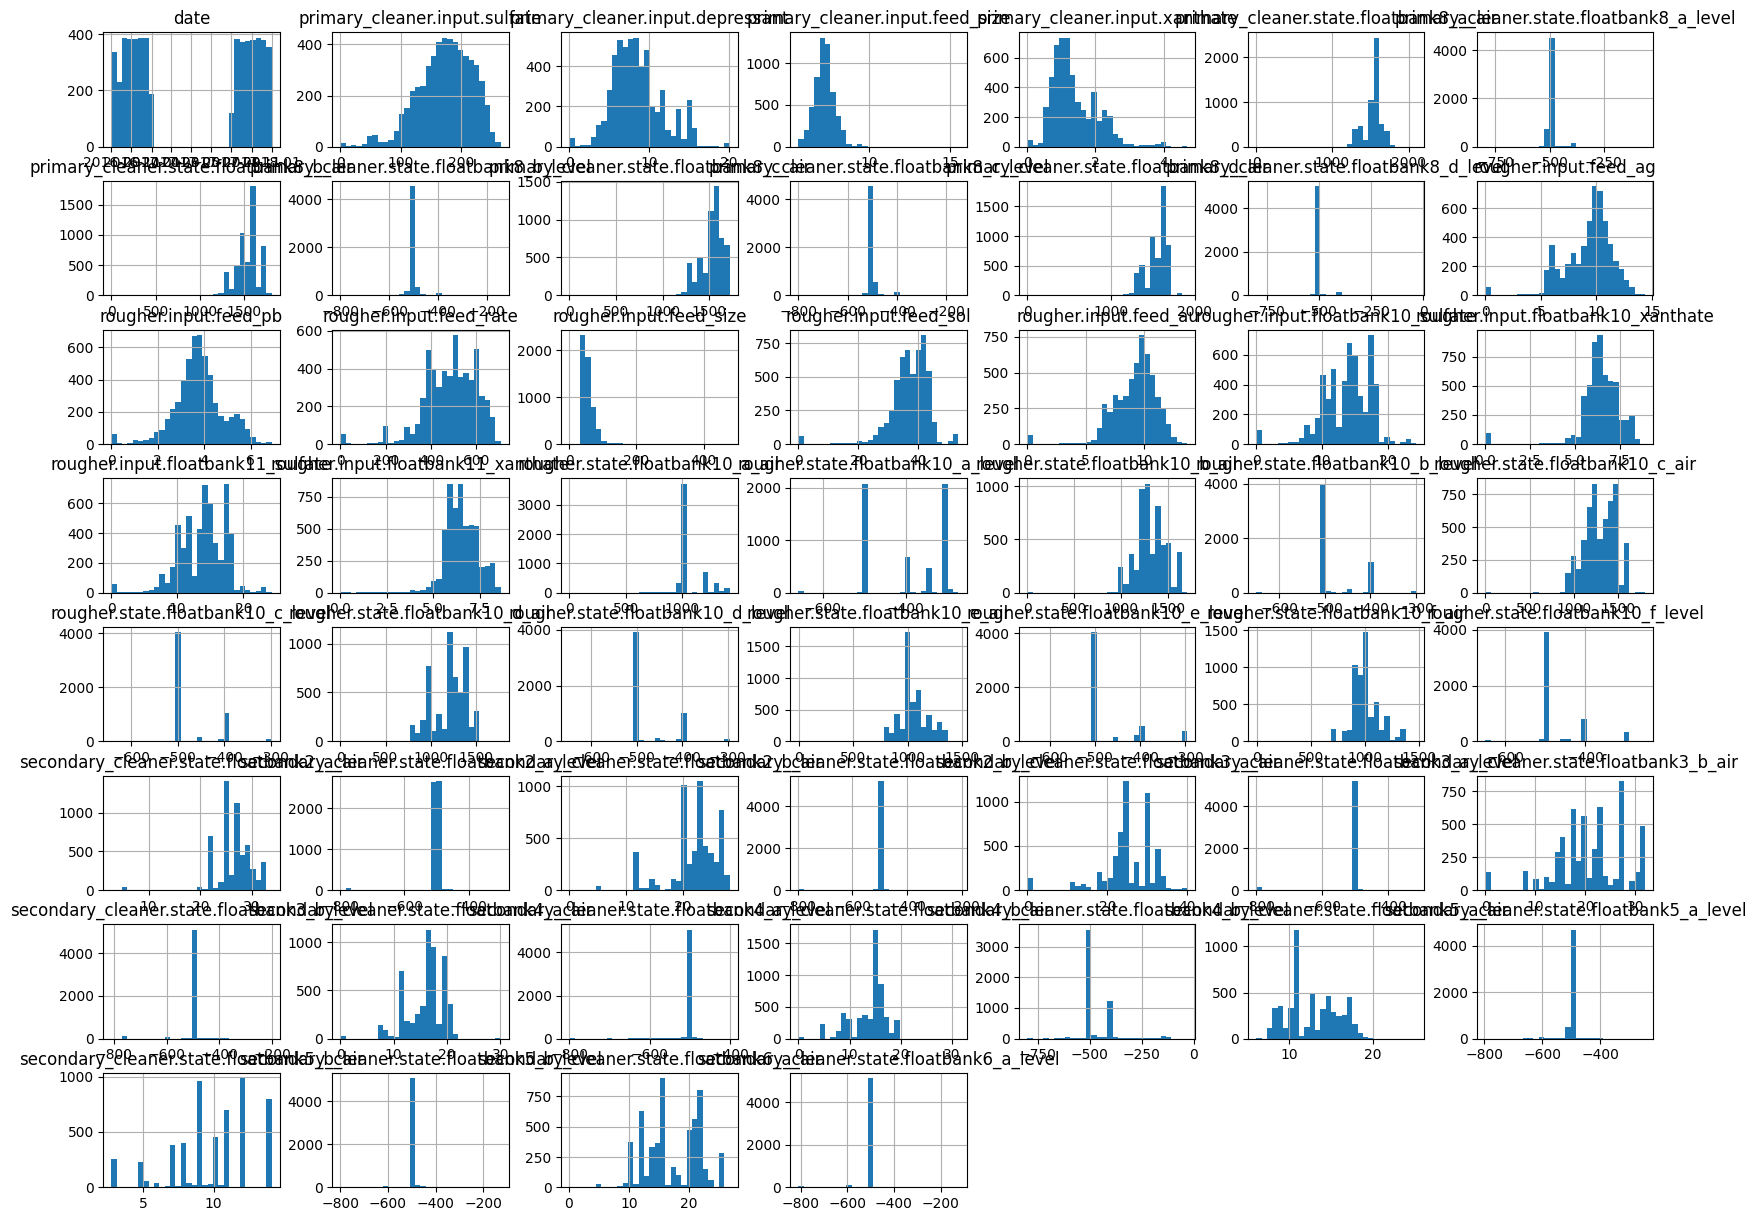

In [68]:
# Finally for our test set, we want to get an idea of the distributions for each column. We will do this visually with histograms
gold_recovery_test.hist(bins=30, figsize= (20,15))
plt.show()

Finally, we will prepare the data for our full set.

In [69]:
# Determine missing values and what percentage of the data are missing 
print(gold_recovery_full.isna().sum().sort_values(ascending=False))
print((gold_recovery_full.isnull().sum()/len(gold_recovery_full)).sort_values(ascending=False).head(20)) #finding the percentage of missing values

rougher.output.recovery                     3119
rougher.output.tail_ag                      2737
rougher.output.tail_au                      2736
rougher.output.tail_sol                     2736
rougher.input.floatbank11_xanthate          2257
                                            ... 
primary_cleaner.state.floatbank8_b_level      43
primary_cleaner.state.floatbank8_c_level      43
primary_cleaner.state.floatbank8_d_level      43
primary_cleaner.input.feed_size                0
date                                           0
Length: 87, dtype: int64
rougher.output.recovery                   0.137304
rougher.output.tail_ag                    0.120488
rougher.output.tail_au                    0.120444
rougher.output.tail_sol                   0.120444
rougher.input.floatbank11_xanthate        0.099357
secondary_cleaner.output.tail_sol         0.097508
final.output.recovery                     0.086415
rougher.calculation.au_pb_ratio           0.071624
primary_cleaner.input.sulfat

It makes sense that our full set seems to have a similar percentage of missing values as our training set. Maintaining the standard we set above we will fill missing values above 5% and drop missing values below that.

In [70]:
full_cols_to_fillna = gold_recovery_full.isna().sum().nlargest(12).index
print(full_cols_to_fillna)

Index(['rougher.output.recovery', 'rougher.output.tail_ag',
       'rougher.output.tail_sol', 'rougher.output.tail_au',
       'rougher.input.floatbank11_xanthate',
       'secondary_cleaner.output.tail_sol', 'final.output.recovery',
       'rougher.calculation.au_pb_ratio', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'rougher.input.floatbank10_sulfate',
       'primary_cleaner.input.xanthate'],
      dtype='object')


In [ ]:
#Determine weather to fill these values with the mean or median value. 
display(gold_recovery_full[full_cols_to_fillna].describe())
#histograms
gold_recovery_full[full_cols_to_fillna].hist(bins=30, figsize= (20,15))
plt.show()

,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_sol,rougher.output.tail_au,rougher.input.floatbank11_xanthate,secondary_cleaner.output.tail_sol,final.output.recovery,rougher.calculation.au_pb_ratio,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,rougher.input.floatbank10_sulfate,primary_cleaner.input.xanthate
count,19597.000000,19979.000000,19980.000000,19980.000000,20459.000000,20501.000000,20753.000000,21089.000000,21107.000000,21170.000000,21415.000000,21565.000000
mean,83.078122,5.587861,18.040138,1.821193,5.962586,6.465460,67.447488,2.386287,140.277672,8.587607,11.784263,0.969830
std,14.661880,1.114614,3.470514,0.695663,1.280682,4.277993,11.616034,0.839999,49.919004,3.611361,4.093125,0.548083
min,0.000000,0.594562,10.014648,0.020676,0.000010,0.000000,0.000000,-0.010548,0.000003,0.000000,0.000002,0.000003
25%,80.941306,4.887758,15.788283,1.403951,5.353321,2.658971,63.282393,2.021360,110.177081,6.018085,9.915698,0.626346
50%,86.144121,5.759630,18.082595,1.808567,6.034551,6.966645,68.322258,2.286493,141.330501,8.018173,11.998801,0.905286
75%,89.987561,6.386301,20.084427,2.215317,6.799526,10.152612,72.950836,2.711070,174.049914,11.003573,14.437582,1.200734
max,100.000000,12.719177,66.117188,9.688980,18.709478,33.058594,100.000000,39.379272,274.409626,40.024582,36.118275,6.027907


Again, based on these data distributions, it seems best to fill the missing values with the median rather than the mean.

In [ ]:
# Fill missing values in these columns 
for col in full_cols_to_fillna:
    gold_recovery_full[col].fillna(gold_recovery_full[col].median(), inplace=True)

# then we will drop any rows that still have missing values in other columns
gold_recovery_full.dropna(inplace=True)

#check that we took care of all the missing values for our training set
print(gold_recovery_full.isna().sum().sum())

In [ ]:
#check for duplicates
print(gold_recovery_full.duplicated().sum())

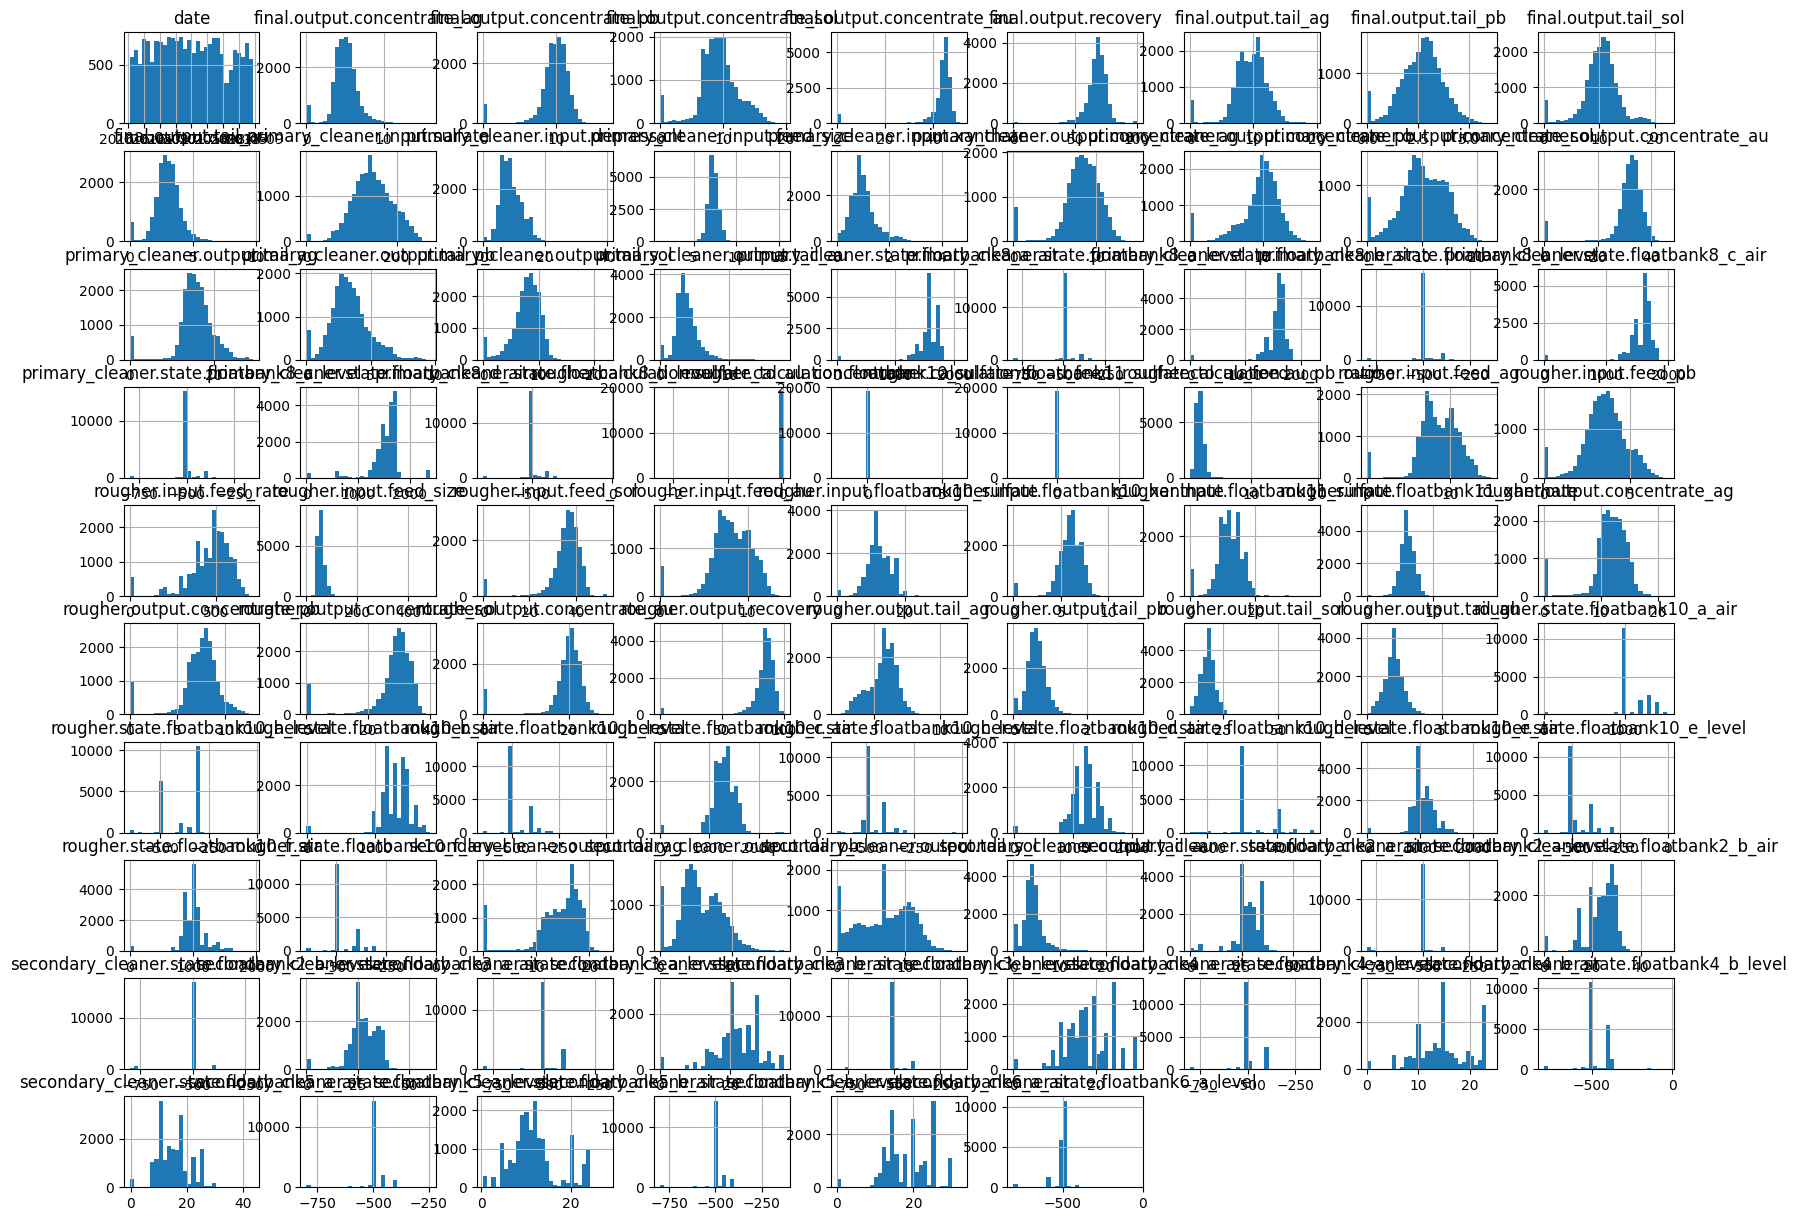

In [74]:
# Finally for our full set, we want to get an idea of the distributions for each column. We will do this visually with histograms
gold_recovery_full.hist(bins=30, figsize= (20,15))
plt.show()

Now, our data in all 3 sets is ready for analysis.  We can also look back at some of these histograms for each section later on to get a quick glimpse of distribution and determine at that point if deeper analysis and a better visual representation is needed.

## Analyze the Data

2.1 Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
To do this we will have to identify each purficiation stage, and then anaylze the change for each metal.  This will best be visualized by a histogram.

In [75]:
#We'll start by creating a function to create histograms for each metal
stages = [
    'rougher.input.feed_{}',
    'rougher.output.concentrate_{}',
    'primary_cleaner.output.concentrate_{}',
    'final.output.concentrate_{}',
]

def progress(metal):
    step = [s.format(metal) for s in stages]
    for i in step:
        gold_recovery_full[i].hist(alpha=0.5, bins=20)
    plt.legend(step)

Text(0.5, 1.0, 'Concentration Changes of Gold Concentration (Au)')

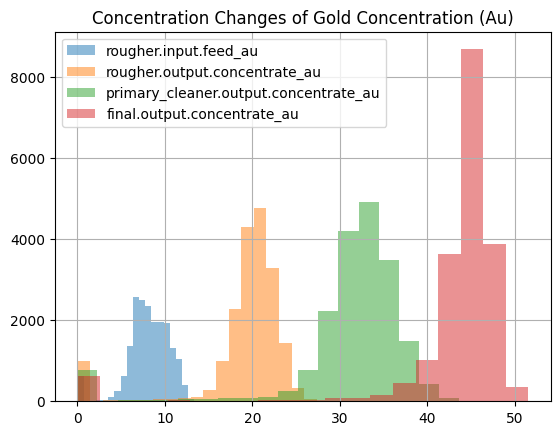

In [76]:
#Then we will plot a histogram for Au
progress('au')
plt.title('Concentration Changes of Gold Concentration (Au)')

As demonstrated by this histogram the concentration of gold significantly increases throughout the purification process, which is what we would want and expect.

Text(0.5, 1.0, 'Concentration Changes of Silver Concentration (Ag)')

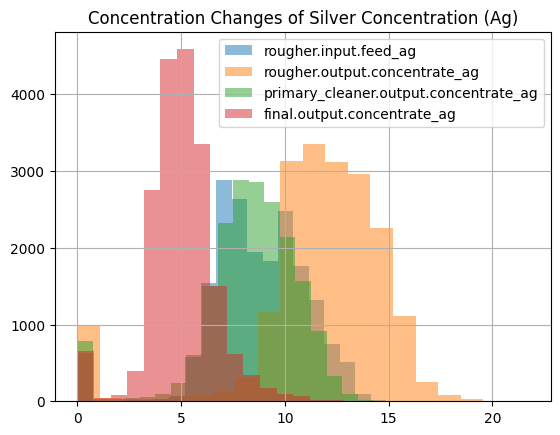

In [77]:
#Plot a histogram for Ag
progress('ag')
plt.title('Concentration Changes of Silver Concentration (Ag)')

The concentration of silver changes throughout the purification process, but not as dramatically as gold.  Overall it slightly decreases throughout the purification process, which again makes sense as we are trying to get gold and not silver.

Text(0.5, 1.0, 'Concentration Changes of Lead Concentration (Pb)')

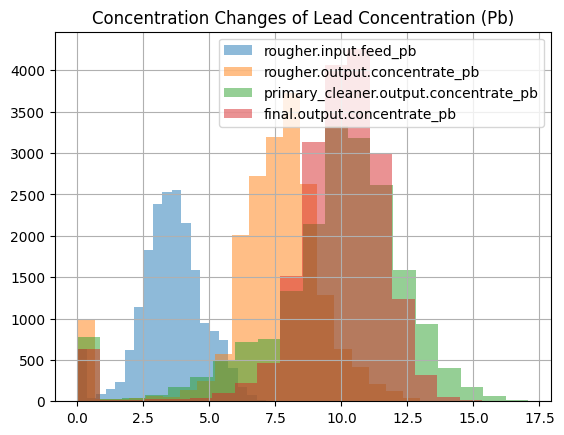

In [78]:
#Then we will plot a histogram for Pb
progress('pb')
plt.title('Concentration Changes of Lead Concentration (Pb)')

Again the concentration of lead changes throughout the purification process, but not as dramatically as gold and overall it slightly decreases throughout the purification process, which again makes sense as we are trying to get gold.

2.2. Compare the feed particle size distributions in the training set and in the test set.

We want to do this because if the distributions vary significantly, the model evaluation will be incorrect.

count    13704.000000
mean        58.884040
std         21.953512
min          9.659576
25%         48.111357
50%         54.449213
75%         64.313685
max        484.967466
Name: rougher.input.feed_size, dtype: float64

count    5439.000000
mean       56.347605
std        21.935856
min         0.046369
25%        43.907462
50%        50.852657
75%        62.444459
max       477.445473
Name: rougher.input.feed_size, dtype: float64

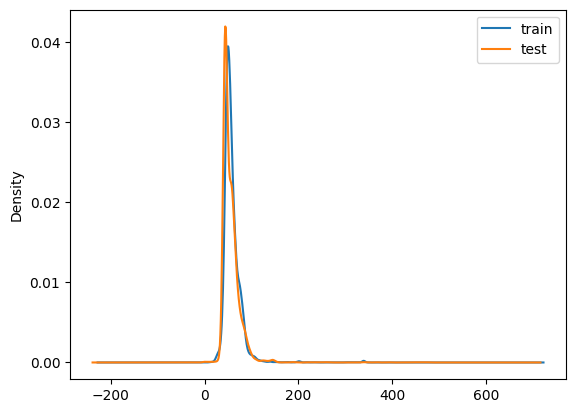

In [79]:
# Compare feed particle size distributions

display(gold_recovery_train['rougher.input.feed_size'].describe())
display(gold_recovery_test['rougher.input.feed_size'].describe())

gold_recovery_train['rougher.input.feed_size'].plot.kde()
gold_recovery_test['rougher.input.feed_size'].plot.kde()
plt.legend(['train', 'test'])

We can see here that the distribution of initial feed particle size is very similar between the training and test sets meaning that the training set will help us accurately create a model.

2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies. 

0


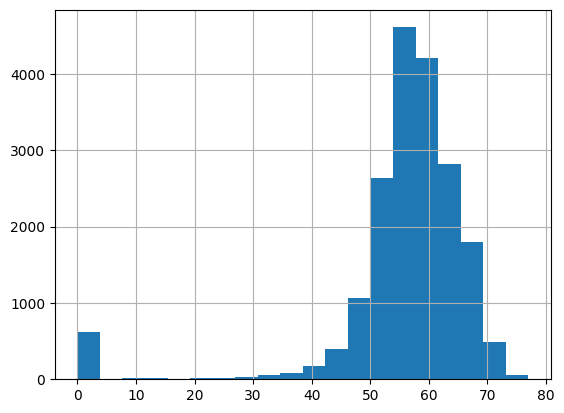

In [80]:
#start by looking raw feed

feature_input = [
    'rougher.input.feed_au',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
]

gold_recovery_full[feature_input].sum(1).hist(bins=20)
print(gold_recovery_full[feature_input].isna().sum().sum())

In the total distribution of raw feed there does seem to be abnormal values in at 0 despite there being no missing values. It may benefit to remove these from our training and test set.

0


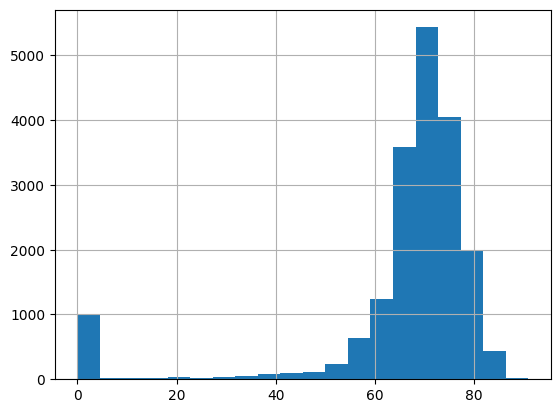

In [81]:
#Rougher Concentrate
feature_output = [
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol',
]

gold_recovery_full[feature_output].sum(1).hist(bins=20)
print(gold_recovery_full[feature_output].isna().sum().sum())

Again, in the rougher concentrate we see anomolies at 0 that would benefit from being removed

0


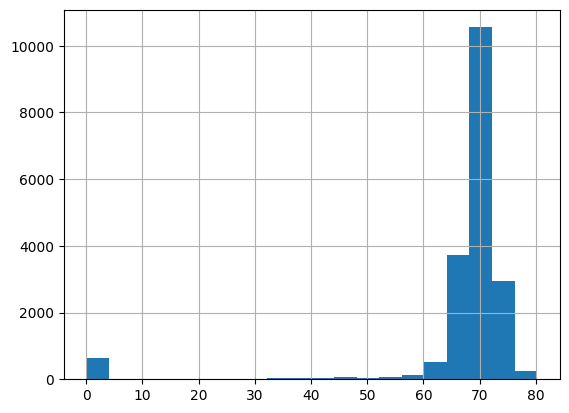

In [82]:
#Final Concentrate

feature_final = [
    'final.output.concentrate_au',
    'final.output.concentrate_ag',
    'final.output.concentrate_pb',
    'final.output.concentrate_sol',
]

gold_recovery_full[feature_final].sum(1).hist(bins=20)
print(gold_recovery_full[feature_final].isna().sum().sum())

There is also some anomaly at 0 in the final concentrate that would benefit from being removed.  These anomalies likely occured because even though we previously took care of missing values, we did not take care of 0 values.

In [83]:
# 0 will be removed

i = 0

#removing 0 from each feature in the training set
gold_recovery_train = gold_recovery_train[gold_recovery_train[feature_input].sum(1) > i]
gold_recovery_train = gold_recovery_train[gold_recovery_train[feature_output].sum(1) > i]
gold_recovery_train = gold_recovery_train[gold_recovery_train[feature_final].sum(1) > i]

#removing 0 from each feature in the test set
df_full_test = gold_recovery_full[gold_recovery_full['date'].isin(gold_recovery_test['date'])].reset_index(drop = True) #matches our test set to our full set to filter based on the full picture
df_full_test = pd.merge(
    gold_recovery_test[['date']],   # just the dates from test
    gold_recovery_full,             # full data with all features
    on='date',
    how='left'                      # ensures all dates from test stay in order
)
df_full_test = df_full_test.reset_index(drop=True)
gold_recovery_test = gold_recovery_test.reset_index(drop=True)
print(len(gold_recovery_test), len(df_full_test),)

gold_recovery_test = gold_recovery_test[df_full_test[feature_input].sum(1) > i]
gold_recovery_test = gold_recovery_test[df_full_test[feature_output].sum(1) > i]
gold_recovery_test = gold_recovery_test[df_full_test[feature_final].sum(1) > i]

print(gold_recovery_train.shape)
print(gold_recovery_test.shape)

5439 5439
(13000, 87)
(5135, 53)


/tmp/ipykernel_32/3497754347.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gold_recovery_test = gold_recovery_test[df_full_test[feature_output].sum(1) > i]
/tmp/ipykernel_32/3497754347.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gold_recovery_test = gold_recovery_test[df_full_test[feature_final].sum(1) > i]


In [84]:
print(gold_recovery_train.isna().sum().sum())

0


## Build the Model

3.1. Write a function to calculate the final sMAPE value.

In [85]:
#First we must identifty our features and targets for our test and training sets.

feature = gold_recovery_test.drop(columns = ['date']).columns.values
target = ['rougher.output.recovery', 'final.output.recovery']

#training set features and target
feature_train = gold_recovery_train[feature].reset_index(drop = True)
target_train = gold_recovery_train[target].reset_index(drop = True)
target_train.columns = [0,1]

#test set features and target
feature_test = gold_recovery_test[feature].reset_index(drop = True)
target_test = gold_recovery_full[target].iloc[gold_recovery_test.index].reset_index(drop = True)
target_test.columns = [0,1]

In [86]:
#creating SMAPE function sMAPE = |yi -y^i|/((|yi| +|y^i|)/2)*100 for the summation over all N obs from i-N

def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true)+np.abs(y_pred))/2
    return((numerator/denominator).mean()*100)

In [87]:
#test function
print(smape(target_train, target_train[0].median()))

0     6.631082
1    24.523352
dtype: float64


In [88]:
#create function for our Final sMAPE = 25% x sMAPE(rougher) + 75% x sMAPE(final)

def final_smape(y_true, y_pred):
    rougher = smape(y_true[0], y_pred[0])
    final = smape(y_true[1], y_pred[1])
    
    return 0.25 * rougher + 0.75 * final

In [89]:
#Run function to get the Final sMAPE values for our training set and our target set

final_smape_train = final_smape(target_train, target_train.median())
print('The Final sMAPE for our training set is:', final_smape_train)
print()
final_smape_test = final_smape(target_test, target_test.median())
print('The Final sMAPE for our test set is:', final_smape_test)

The Final sMAPE for our training set is: 8.509259961893742

The Final sMAPE for our test set is: 9.444090818811096


3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

In [90]:
# create a function to train model with cross-validation to determine the best model.

#define our function to evaluate the model using K-Fold Cross-Validation and return average sMAPE scores
def score_model(model, cv = 4):
    score = []
 
    for subtrain_index, valid_index in KFold(n_splits=cv).split(feature_train): #creating the cross-validation loop
        
        #extract subtraining set to fit the models
        feature_subtrain = feature_train.loc[subtrain_index].reset_index(drop = True) 
        target_subtrain = target_train.loc[subtrain_index].reset_index(drop = True)
        
        #extract validation set to predict on and score
        feature_valid = feature_train.loc[valid_index].reset_index(drop = True)
        target_valid = target_train.loc[valid_index].reset_index(drop = True)
        
        #train the model
        model.fit(feature_subtrain, target_subtrain)
        
        #make predictions on validation set and wrap into a DF so that final_sampe can take it
        pred_valid = pd.DataFrame(model.predict(feature_valid))
        
        #score the predictions using sMAPE and add to the score list
        score.append(final_smape(target_valid, pred_valid))
        
    return pd.Series(score).mean()

I decided to create a function to use cross-validation rather than use the sklearn cross_val_score so that I can use a custom metric (in our case sMAPE), and to be able to run multiple models through it more easily.

In [91]:
# test Linear Regression Model

model = LinearRegression()
linear_score = score_model(model)
print('LR : ', linear_score)

LR :  9.238835182818319


In [ ]:
# test Random Forest Model with different depths to determine best hyperparameters

for depth in range(1,5):
    model = RandomForestRegressor(max_depth= depth, n_estimators = 50, random_state=12345)
    score = score_model(model)
    print('Random Forest, depth = ', depth, 'score = ', score)

Random Forest, depth =  1 score =  8.745131452009122
Random Forest, depth =  2 score =  8.398318741449732
Random Forest, depth =  3 score =  8.352308596561386


A Random Forest Regressor Model with a max_depth of 3 gives us our best sMAPE score.  So we will now run it with our training set and test set.

In [93]:
model = RandomForestRegressor(max_depth= 3, n_estimators = 50, random_state=12345)
model.fit(feature_train, target_train)

predict = pd.DataFrame(model.predict(feature_train))
print('train : ', final_smape(target_train, predict))

predict = pd.DataFrame(model.predict(feature_test))
print('test : ', final_smape(target_test, predict))

train :  6.711095953240093
test :  11.634222306022163


## Conclusion

What we found on testing our model is that our sMAPE for our training set is lower at 6.71% than our test set at 11.63%, which means that the model is better at predicting the target variable on our training set. But, overall still getting a sMAPE of under 15% on our test set does show overall good accuracy in predicting gold output recovery.  Therefore, we can use this model with a good amount of confidence to predict the amount of gold recovered from gold ore which can help optimize the overall production.